# 0000 UTC WoFS initialization PW and MLCAPE

## Setup

In [2]:
# Import statements
from typing import List, Union

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401
import xarray as xr
from metpy.io import parse_wpc_surface_bulletin
from metpy.plots import (
    ColdFront,
    OccludedFront,
    StationaryFront,
    StationPlot,
    WarmFront,
)
from scipy.ndimage import gaussian_filter

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True

In [3]:
# Define useful functions
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


def get_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Return a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [w[varname].sel(time=slice(start_time, end_time)) for w in wofs_list],
        dim=init_dim,
    ).chunk({"init": -1})

def get_smoothed_ds(da: xr.DataArray, sigma: Union[float, int], axes: Union[str, List[str]] = None):
    """
    Apply a Gaussian filter to specific dimensions of an xarray.DataArray and return 
    a Dataset containing both the original and smoothed data.

    Parameters:
    - da (xr.DataArray): Input data array.
    - sigma (float or int): Standard deviation for the Gaussian kernel.
    - axes (str or List[str], optional): Dimensions to smooth over. Defaults to all dimensions.

    Returns:
    - xr.Dataset: A dataset containing the original and smoothed DataArrays.
    """
    # Type checking
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray.DataArray.")
    if not isinstance(sigma, (float, int)):
        raise TypeError("Sigma must be a float or an integer.")
    if axes is not None and not isinstance(axes, (str, list)):
        raise TypeError("Axes must be a string, a list of strings, or None.")

    # Convert a single axis string to a list
    if isinstance(axes, str):
        axes = [axes]

    # If no axes specified, apply to all dimensions
    if axes is None:
        axes = list(da.dims)

    # Convert dimension names to axis indices
    try:
        axis_indices = [da.get_axis_num(dim) for dim in axes]
    except ValueError as e:
        raise ValueError(f"Invalid axis name in {axes}: {e}")

    # Construct full sigma array where only selected axes are smoothed
    full_sigma = [sigma if i in axis_indices else 0 for i in range(da.ndim)]

    # Apply the Gaussian filter
    smoothed_data = gaussian_filter(da.values, sigma=full_sigma)

    # Create a new DataArray with the same metadata
    smoothed_da = xr.DataArray(
        smoothed_data,
        dims=da.dims,
        coords=da.coords,
        attrs={**da.attrs, 'description': f'Gaussian smoothed (sigma={sigma}) over {axes}'}
    )

    # Combine original and smoothed data into a Dataset
    ds = xr.Dataset({'original': da, 'smoothed': smoothed_da})

    return ds


In [4]:
# Load in 0000 UTC initializations
wofs_0000 = get_wofs_all(0)

# Define variables and parameters
lat = wofs_0000.xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_0000.xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_0000.attrs["CEN_LON"],
    central_latitude=wofs_0000.attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # WoFS projection

/tmp/ipykernel_3604465/949845812.py:16: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


In [5]:
# Extract PW and mlcape for first time only while taking ensemble mean
pw = wofs_0000.pw.isel(time=0).mean(dim="ne").squeeze().drop_vars("time")
mlcape = wofs_0000.cape_ml.isel(time=0).mean(dim="ne").squeeze().drop_vars("time")

df = parse_wpc_surface_bulletin(
    "data/nws_coded_surface_bulletin_090225_hires.txt"
)

# Set MetPy styles
size=2.5
fontsize=8
complete_style = {
    "HIGH": {"color": "blue", "fontsize": fontsize},
    "LOW": {"color": "red", "fontsize": fontsize},
    "WARM": {"linewidth": 0.8, "path_effects": [WarmFront(size=size)]},
    "COLD": {"linewidth": 0.8, "path_effects": [ColdFront(size=size)]},
    "OCFNT": {"linewidth": 0.8, "path_effects": [OccludedFront(size=size)]},
    "STNRY": {"linewidth": 0.8, "path_effects": [StationaryFront(size=size)]},
    "TROF": {"linewidth": 0.8, "linestyle": "dashed", "edgecolor": "darkorange"},
}


## Plotting

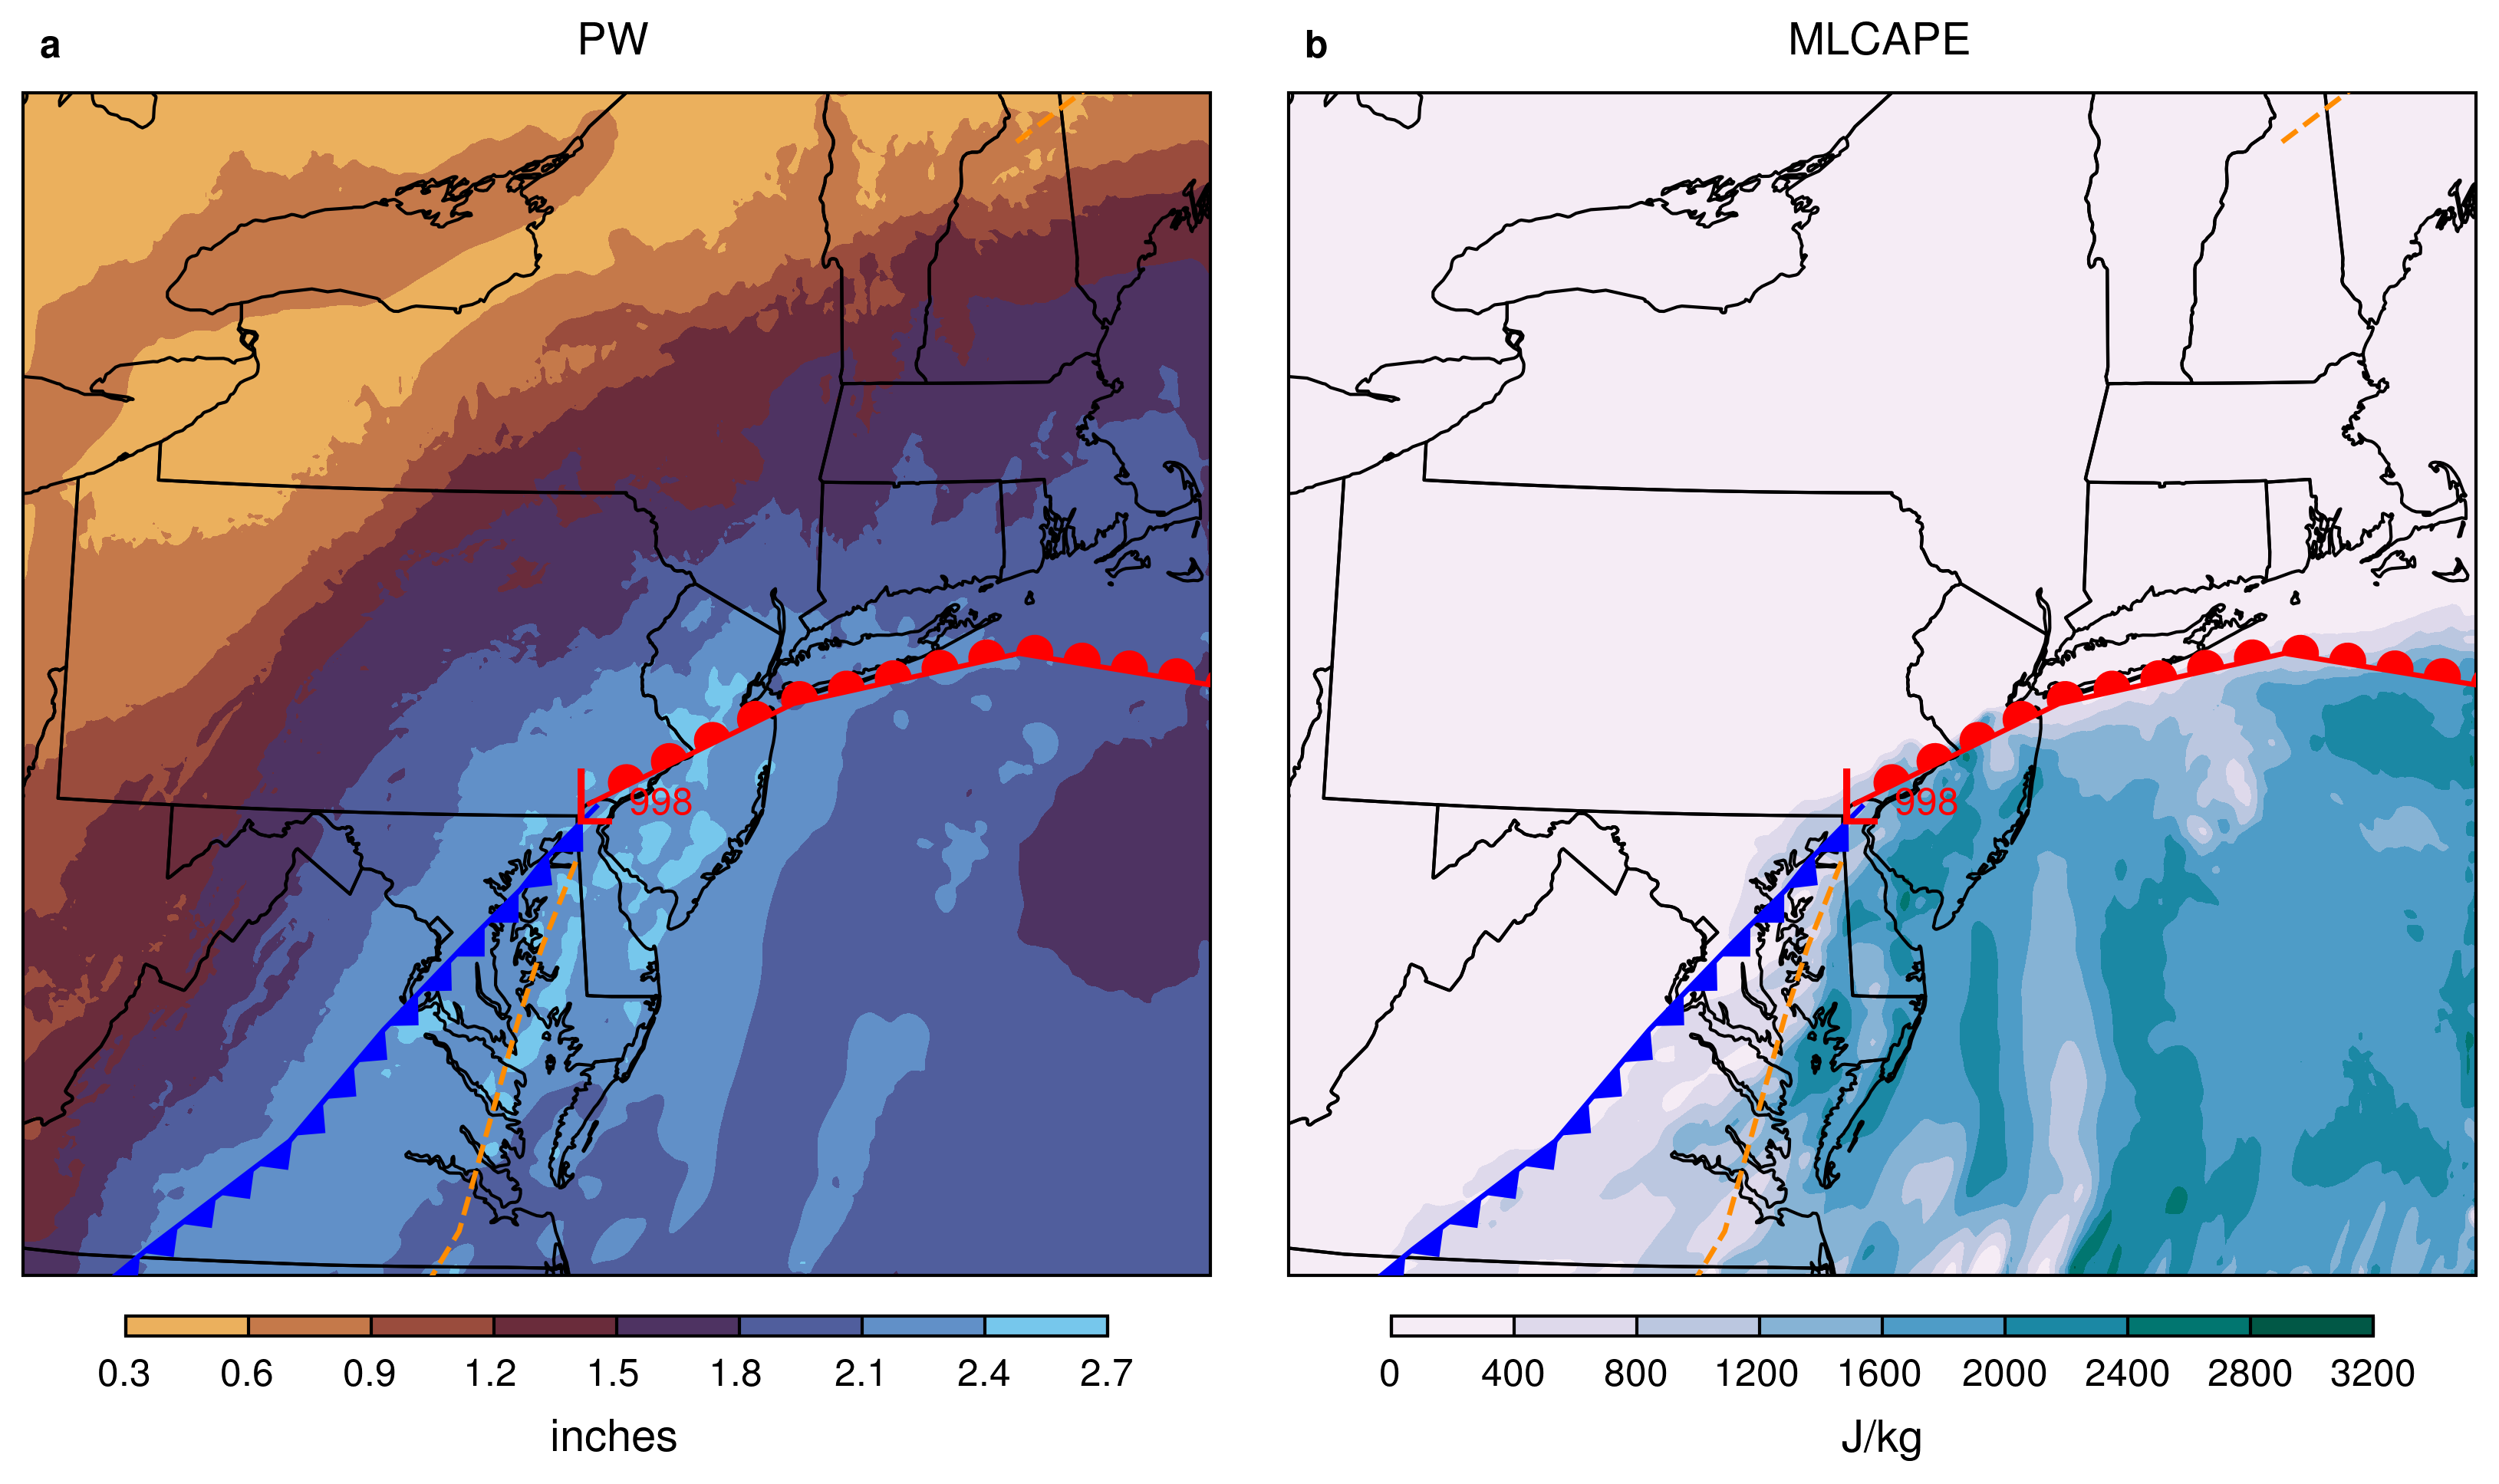

In [6]:
titles = ["PW", "MLCAPE"]
fields = [pw, mlcape]
cmaps = ["managua", "PuBuGn"]
letters = ["a", "b"]
labels = ["inches", "J/kg"]

# Contour fill pw and mlcape
fig, axes = plt.subplots(
    1,
    2,
    figsize=(5.5, 3.2),
    dpi=600,
    subplot_kw={"projection": proj},
    layout="constrained",
)

# Iterate through axes
for i, ax in enumerate(axes):
    cf = ax.contourf(
        lon, lat, fields[i], transform=ccrs.PlateCarree(), cmap=cmaps[i], zorder=1
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="black", zorder=2)

    ax.set_title(titles[i], fontsize=7)

    # Create a shared horizontal colorbar below each plots
    cb = fig.colorbar(
        cf,
        ax=ax,
        orientation="horizontal",
        pad=0.03,
        aspect=50,
        shrink=0.8,
    )

    cb.set_label(labels[i], fontsize=7)
    cb.ax.tick_params(labelsize=6)

    # Add fronts
    for field in ["WARM", "COLD", "STNRY", "OCFNT", "TROF"]:
        ax.add_geometries(
            df[df.feature == field].geometry,
            crs=ccrs.PlateCarree(),
            **complete_style[field],
            facecolor="None",
            zorder=3,
        )

    rows = df[(df.feature == "LOW") & (df.strength == 998.0)]
    x, y = zip(*((pt.x, pt.y) for pt in rows.geometry))
    sp = StationPlot(ax, x, y, transform=ccrs.PlateCarree(), clip_on=True)
    sp.plot_text("C", "L", color="red", fontsize=12, fontweight="heavy", zorder=4)
    sp.plot_parameter("E", rows.strength, color="red", fontsize=6)

    ax.text(
        0.015, 1.03, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=6
    )

# Save fig
plt.savefig("figures/Fig4_init_PW_MLCAPE.pdf", bbox_inches="tight")